# Inicialización y preprocesamiento de datos

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from IPython.display import  HTML 
import math

sb.set()

In [10]:
all_data = np.load('dataset/proyecto_training_data.npy')
n_training_rows   = int(len(all_data) * 0.8)
training_data = all_data[:n_training_rows]
testing_data  = all_data[n_training_rows:]

print("training rows:  ", len(training_data))
print("testing  rows:  ", len(testing_data))
print("total data rows:", len(all_data))

training rows:   1168
testing  rows:   292
total data rows: 1460


In [11]:
# preprocessing
training_data[:,0] /= 1000 # expresar precio de venta en miles de dólares
training_data[:,2] /= 1000 # expresar pies cuadrados en el primer nivel en miles de pies^2


variables   = {}
for column, name in enumerate(('sale_price', 'quality', 'fst_fl_sqf', 'total_rooms', 'year_built', 'lot_front')):
    variables[name] = training_data[:,column]
    globals()[name] = training_data[:,column]
    

# Análisis exploratorio de datos

### Resumen de variables

In [12]:
rows = []
for name, values in variables.items():
    mean  = np.nanmean(values)
    max_v = np.nanmax(values)
    min_v = np.nanmin(values)
    rng   = max_v - min_v
    std   = np.nanstd(values)
    rows.append({'avg': mean, 'min': min_v, 'max': max_v, 'range': rng, 'std': std})
    
df = pd.DataFrame(rows, index=variables.keys()).round(2)
HTML(df.to_html())

,avg,min,max,range,std
sale_price,180.59,34.90,755.00,720.10,78.78
quality,6.10,1.00,10.00,9.00,1.38
fst_fl_sqf,1.16,0.33,3.23,2.89,0.37
total_rooms,6.49,2.00,14.00,12.00,1.61
year_built,1971.45,1875.00,2010.00,135.00,29.94
lot_front,69.95,21.00,313.00,292.00,23.47


### Histogramas

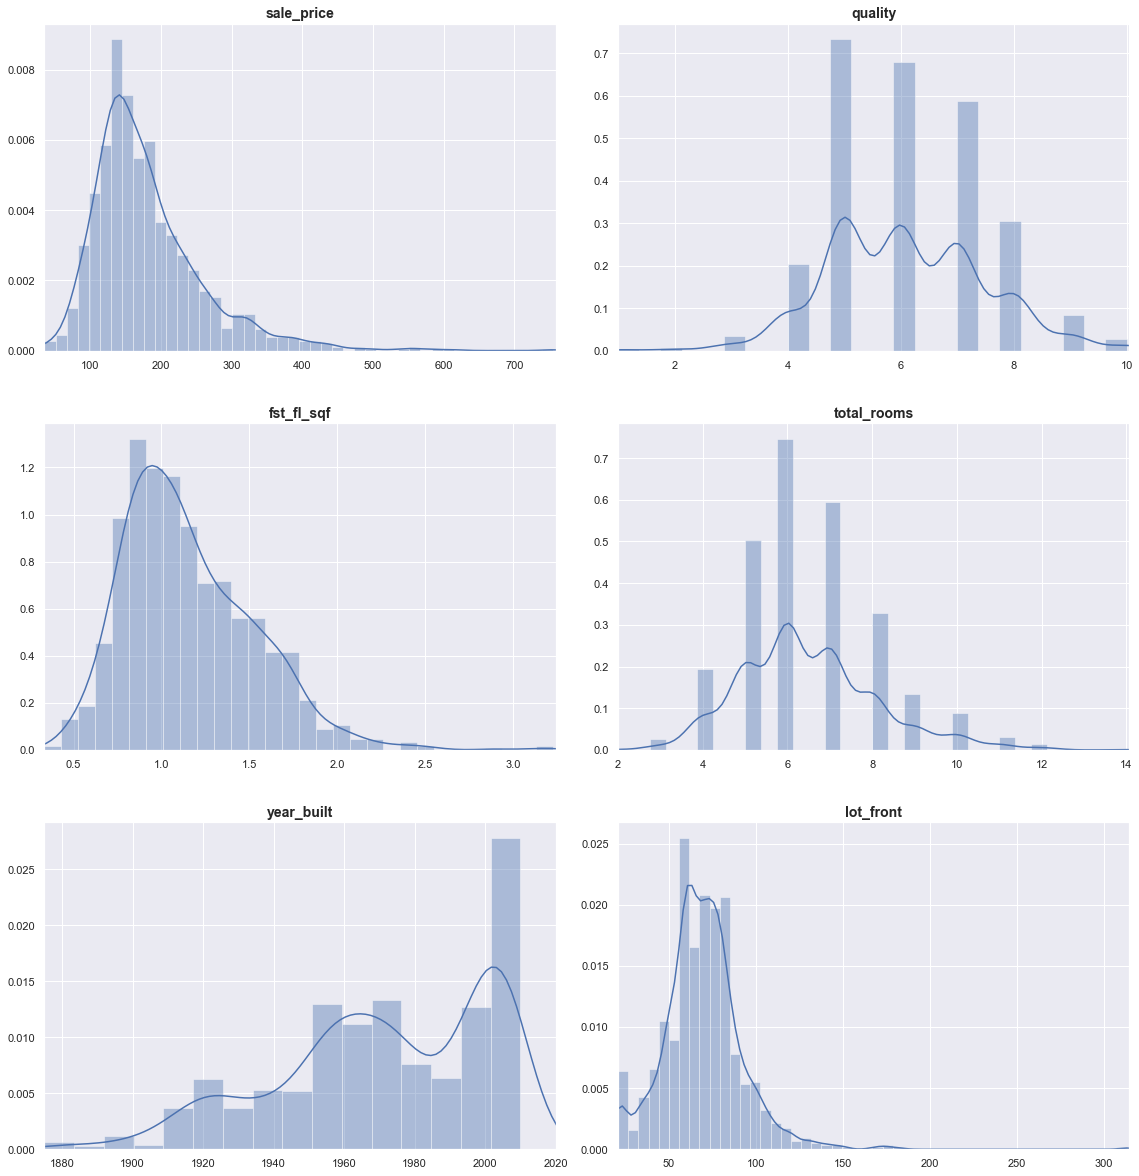

In [116]:
n = len(variables)
cols = 2
rows = n // cols

fig,ax = plt.subplots(rows, cols, figsize=(16,n*2.75))

i = 0
for name, values in variables.items():
    current_ax = ax[i//cols][i%cols]
    current_ax.set_title(name,  weight='bold').set_fontsize(14)
    current_ax.set_xlim(np.nanmin(values), np.nanmax(values) * 1.005)
    sb.distplot(values[~np.isnan(values)],  ax=current_ax)
    i+=1

fig.tight_layout(h_pad=3)

### Correlación entre variables

In [14]:
independent_vars = [(name,values) for name,values in variables.items()][1:]

for name, values in independent_vars:
    not_nan = ~np.isnan(values)
    values = values[not_nan]
    print(name, np.corrcoef(values, sale_price[not_nan])[1][0]) #TODO make dataframe

quality 0.7939900504626412
fst_fl_sqf 0.6162887000998714
total_rooms 0.5647069399593065
year_built 0.5341706927117518
lot_front 0.36329161665389204


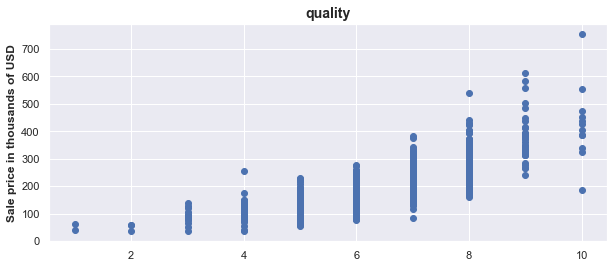

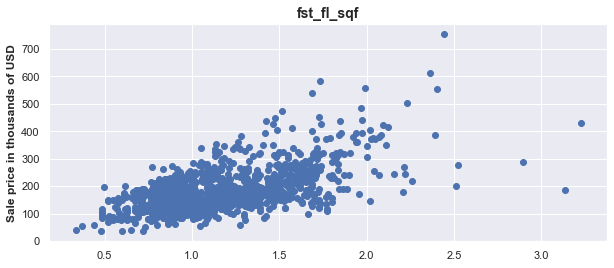

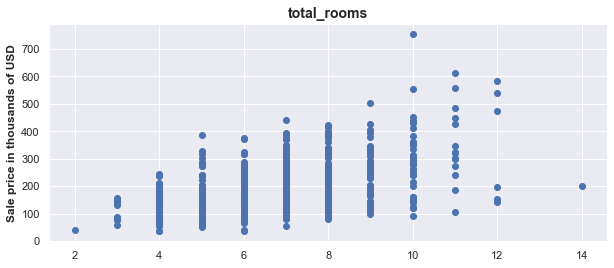

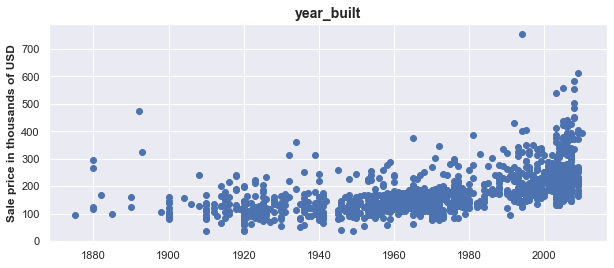

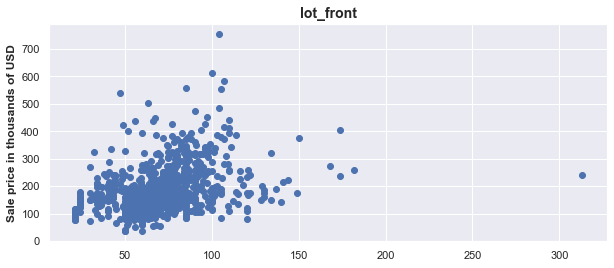

In [15]:
for name, values in independent_vars:
    plt.figure(figsize=(10,4))
    plt.scatter(x = values, y = sale_price)
    plt.ylabel("Sale price in thousands of USD", weight='bold')
    plt.gca().set_title(name,  weight='bold').set_fontsize(14) #TODO include r from dataframe above

## Selección de variables
De las gráficas y coeficientes de correlación de arriba, notamos que quality (r=0.79399) y fst_fl_sqf (r=0.61628) son las dos variables independientes que muestran mayor correlación con el precio de venta. Estas dos serán las variables para las que desarrollaremos modelos de regresión.

# Entrenamiento manual del modelo
#### Función de entrenamiento

In [172]:
# Función de entrenamiento
def train(x, y, epochs, error_report_rate, learning_rate):
    linear_regression_params = np.array([0.0, 0.0])
    error_history = np.zeros([epochs])
    param_history = np.zeros([epochs, 2])
    
    x = np.vstack((x, np.ones_like(x)))

    for epoch in range(0, epochs):
        y_hat = np.matmul(linear_regression_params, x)

        gradients = np.average((y_hat - y) * x, axis=1)
        
        linear_regression_params -= (learning_rate * gradients)
        
        error_history[epoch] = 0.5 * np.average(np.power(y - y_hat, 2))
        param_history[epoch] = linear_regression_params.copy()
        
        if epoch % error_report_rate == 0 or epoch == epochs - 1:
            print("epoch:", epoch, "error:", error_history[epoch])
    
    return (param_history, error_history)

#### Funciones de visualización


In [173]:
def plot_error(error_data, ax=None):
    if ax is None:
        ax = plt.gca()
    x = range(0, len(error_data))
    return ax.plot(x, error_data)

def plot_model_progress(model_data, x, y, n, x_label=''):
    num_plots = len(model_data) // n
    cols = 2
    rows = math.ceil(num_plots / cols)
    
    fig,ax = plt.subplots(rows, cols, figsize=(16,num_plots*2.75))

    for i in range(0, num_plots):
        epoch = n * i
        current_ax = ax[i // cols][i % cols]
        current_model = model_data[epoch]
        
        # scatter
        current_ax.scatter(x = x, y = y)
        
        # model line
        m,b = current_model[0], current_model[1]
        y_hat = m * x + b
        current_ax.plot(x, y_hat, 'k--')
        
        # text
        title = 'epoch ' + str(epoch) + ': m=' + str(round(m, 2)) + ' b=' + str(round(b,2))
        current_ax.set_title(title, weight='demi').set_fontsize(14)
        if i == 0:
            current_ax.set_ylabel("Sale price in thousands of USD", weight='semibold')
            current_ax.set_xlabel(x_label, weight='semibold')
        
    
    fig.subplots_adjust(hspace=0.4)
    
    if num_plots % cols != 0:
        ax[-1][-1].axis('off')


### Ajuste de parámetros del modelo: epochs y learning rate
#### variable independiente 1: overall quality

epoch: 0 error: 19409.722053221747
epoch: 100 error: 1994.6604300388435
epoch: 200 error: 1974.1466188818783
epoch: 300 error: 1959.6442472792978
epoch: 400 error: 1949.3892163320418
epoch: 500 error: 1942.1375982780137
epoch: 600 error: 1937.0097771459307
epoch: 700 error: 1933.383751979309
epoch: 800 error: 1930.81968857493
epoch: 900 error: 1929.006567915373
epoch: 999 error: 1927.7352060007693


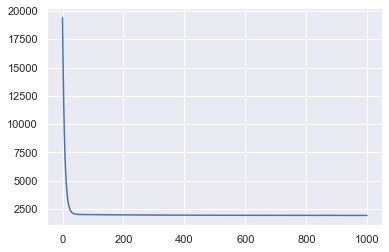

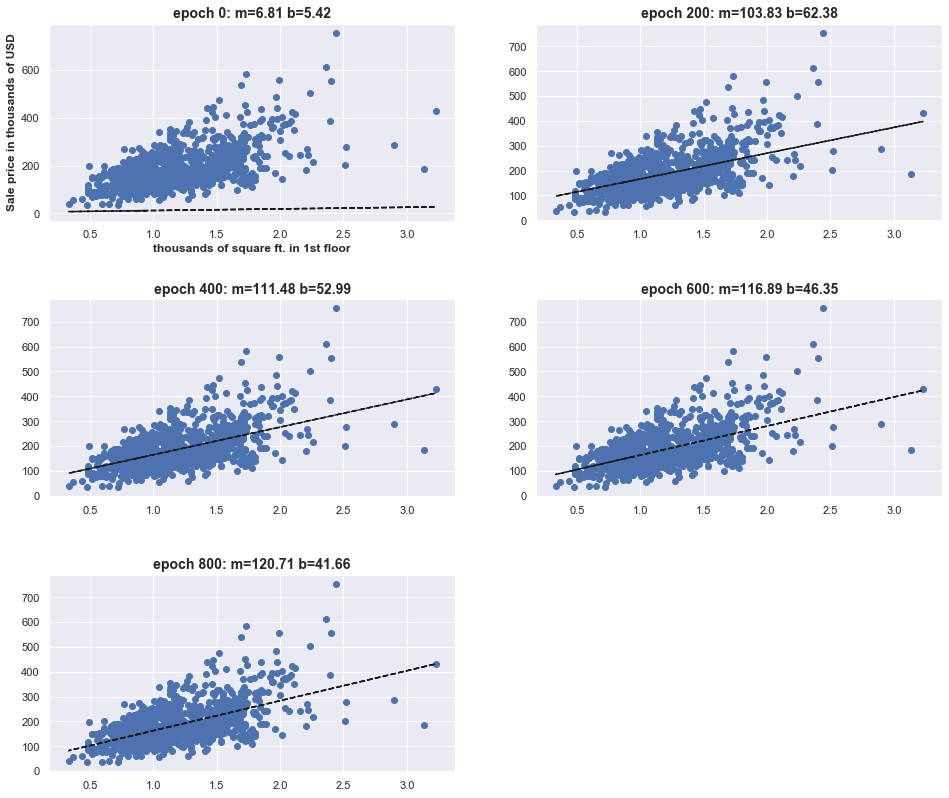

In [174]:
model, errors = train(fst_fl_sqf, sale_price, 1000, 100, 0.03)

plot_error(errors)
plot_model_progress(model, fst_fl_sqf, sale_price, 200, 'thousands of square ft. in 1st floor')